# 2021公投社群網路分析

**Author:** 林昱秀、邢學皓、焦玉茹、陳亞琦、朱淓璘、顏廷諭<br>
**資料來源:** 文字平台收集PTT Gossip版<br>
**資料集:** vote_articleMetaData.csv; vote_articleReviews.csv<br>
**關鍵字:** 四個不同意 四個同意 公投 公投結果 1218 開票 重啟核四 核四 反萊豬進口 反萊豬 萊豬 公投綁大選 珍愛藻礁 黃士修<br>
**資料時間:** 2021/11/22 ~ 2021/12/21<br>
**資料筆數:** 共 5740 篇文章、403564 篇回文<br>

這次我們針對110年12/18日全國性公民投票公投事件，討論ptt版上相關討論的發文風向。<br>
我們會先透過LDA為資料進行主題分析，再以不同角度對社群進行篩選，進行網路分析。<br>
主要針對以下方向分析：
 1. 公投的討論的主題有哪些? 主題的風向為何?
 2. 風向最偏哪邊?
 3. 討論社群網路如何分布?
 4. 意見領袖有誰?網友的推噓狀態如何?  

## 大綱

- 1. 套件說明
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
- 3. LDA
    - 3.1 LDA資料準備
    - 3.2 建立LDA
    - 3.3 判斷每筆發文
    - 3.4 資料內容探索
    - 3.5 N-gram 字詞相關網路圖
- 4. 社群網路圖
    - 4.1 基本網路圖
    - 4.2 資料篩選
    - 4.3 以日期篩選社群
    - 4.4 以主題篩選社群
    - 4.5 使用者是否受到歡迎


## 1. 套件說明

下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer,TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。
- gensim: 主題模型函式庫
- pyLDAvis: 互動式LDA視覺化套件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
#import pyLDAvis.gensim_models

In [3]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 2.資料前處理

### 2.1 基本資料介紹

In [5]:
#匯入資料
MetaData = pd.read_csv('./raw_data/vote_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/vote_articleReviews.csv', encoding='UTF-8')

In [9]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum
0,Re:[新聞]1218公投》黃士修嗆許永輝「身家安頓好了,2021/11/21,16:02:01,https://www.ptt.cc/bbs/Gossiping/M.1637510532....,DCHC,Gossiping,16,0,4,[del.]\n辯論雙方應該要有禮貌，但是中國民主進步黨不應該利用這件事鬧事。\n許處長說得...,4
1,Re:[新聞]核四重啟要多久林飛帆：至少要7至10年,2021/11/21,16:31:21,https://www.ptt.cc/bbs/Gossiping/M.1637512283....,ThisisLongID,Gossiping,15,5,0,好了啦 你民進黨還敢講什麼屁話\n\n上半年幹話好幾個月 什麼「我敢說現在疫苗就是買不到」 ...,5
2,Re:[新聞]核四重啟要多久林飛帆：至少要7至10年,2021/11/21,16:36:56,https://www.ptt.cc/bbs/Gossiping/M.1637512618....,s2678132,Gossiping,9,3,2,真的覺得塔綠班的人都有夠不要臉，很喜歡講唬爛的東西洗腦\n\n他媽的都2021了，還在那邊拼...,5


In [10]:
MetaData['sum']=MetaData['push']+MetaData['boo']

In [11]:
MetaData.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum
0,Re:[新聞]1218公投》黃士修嗆許永輝「身家安頓好了,2021/11/21,16:02:01,https://www.ptt.cc/bbs/Gossiping/M.1637510532....,DCHC,Gossiping,16,0,4,[del.]\n辯論雙方應該要有禮貌，但是中國民主進步黨不應該利用這件事鬧事。\n許處長說得...,4
1,Re:[新聞]核四重啟要多久林飛帆：至少要7至10年,2021/11/21,16:31:21,https://www.ptt.cc/bbs/Gossiping/M.1637512283....,ThisisLongID,Gossiping,15,5,0,好了啦 你民進黨還敢講什麼屁話\n\n上半年幹話好幾個月 什麼「我敢說現在疫苗就是買不到」 ...,5
2,Re:[新聞]核四重啟要多久林飛帆：至少要7至10年,2021/11/21,16:36:56,https://www.ptt.cc/bbs/Gossiping/M.1637512618....,s2678132,Gossiping,9,3,2,真的覺得塔綠班的人都有夠不要臉，很喜歡講唬爛的東西洗腦\n\n他媽的都2021了，還在那邊拼...,5
3,Re:[問卦]看完核四弊案自白後堅定重啟的人多嗎?,2021/11/21,16:39:03,https://www.ptt.cc/bbs/Gossiping/M.1637512746....,DCHC,Gossiping,4,0,0,[del.]\n你應該記得曾經有一位立法委員，為了調查核四工程品質，\n 而被中國民主...,0
4,[問卦]為什麼公投會變成黨爭？,2021/11/21,16:41:00,https://www.ptt.cc/bbs/Gossiping/M.1637512862....,aaa95308,Gossiping,6,2,0,餓死抬頭\n\n\n這應該不算政問ㄅ\n\n按理來說公投項目和支持政黨ㄉ原因不一定相同，即使...,2


In [12]:
MetaData['sum'] = MetaData['sum'].astype(int)

In [13]:
# 拿掉推文和噓文數量小於30的文章
MetaData = MetaData.drop(MetaData[MetaData['sum'] < 30].index)

In [14]:
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum
16,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021/11/22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,1.媒體來源:\n自由時報\n\n\n〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導...,52
17,[新聞]許永輝：核四運轉測試難過關,2021/11/22,01:34:09,https://www.ptt.cc/bbs/Gossiping/M.1637544853....,Uizmp,Gossiping,240,64,48,1.媒體來源: 聯合新聞網 (經濟日報)\n\n2.記者署名: 鄭鴻達\n\n3.完整新聞標...,112
28,Re:[新聞]許永輝：核四運轉測試難過關,2021/11/22,02:46:55,https://www.ptt.cc/bbs/Gossiping/M.1637549217....,assxass,Gossiping,78,27,4,"看了這些發言 我真的頭很痛\n你弄得我好亂啊\n尤其是這句\n\n""因此，我的簽名是保證數據...",31
33,[新聞]顏寬恒嗆高端成「4劑疫苗」林靜儀：讓國,2021/11/22,03:24:06,https://www.ptt.cc/bbs/Gossiping/M.1637551448....,coffee112,Gossiping,126,23,34,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n聯合新聞網\n\n\n2.記者署名...,57
36,[新聞]超商店員規勸顧客戴口罩遭刺民進黨團建,2021/11/22,03:33:01,https://www.ptt.cc/bbs/Gossiping/M.1637551984....,youhow0418,Gossiping,296,28,138,超商店員規勸顧客戴口罩遭刺 民進黨團建議用舉發避免衝突\n\nETtoday新聞雲\n\n記...,166
...,...,...,...,...,...,...,...,...,...,...,...
5719,[問卦]413萬人決定2300萬人未來會不會笑死人,2021/12/21,12:47:33,https://www.ptt.cc/bbs/Gossiping/M.1640090855....,SungHyun,Gossiping,144,35,42,再說一次\n台灣配不上民主\n說的就是南部人\n這次血淋淋演示了一次這句話\n\n413萬人...,77
5722,[新聞]蘇貞昌選總統壯志已塵封？陳水扁：未來,2021/12/21,13:08:16,https://www.ptt.cc/bbs/Gossiping/M.1640092098....,go190214,Gossiping,69,25,8,1.媒體來源:\n2.記者署名:\n3.完整新聞標題:\n4.完整新聞內文:\n\n四大公投...,33
5723,[新聞]柯文哲再出狂言「越文明國家投票率不會,2021/12/21,13:13:36,https://www.ptt.cc/bbs/Gossiping/M.1640092418....,Derozan12,Gossiping,143,55,27,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源: 中時\n\n2.記者署名: 吳亮賢\...,82
5730,[新聞]快訊／黃士修為3倍券槓台大生 「不用功,2021/12/21,14:11:37,https://www.ptt.cc/bbs/Gossiping/M.1640095900....,XXXXGGYY,Gossiping,445,307,25,1.媒體來源:\nETtoday\n\n2.記者署名:\n黃宥寧\n\n3.完整新聞標題:\...,332


In [15]:
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,Re:[新聞]1218公投》黃士修嗆許永輝「身家安頓好了,2021/11/21,16:02:01,https://www.ptt.cc/bbs/Gossiping/M.1637510532....,DCHC,Gossiping,eric999,→,2021-11-22 00:15:00,:鄭麗文都承認公投案只是為了讓執政黨難
1,Re:[新聞]1218公投》黃士修嗆許永輝「身家安頓好了,2021/11/21,16:02:01,https://www.ptt.cc/bbs/Gossiping/M.1637510532....,DCHC,Gossiping,eric999,→,2021-11-22 00:15:00,:看核安什麼的他們應該不在乎
2,Re:[新聞]1218公投》黃士修嗆許永輝「身家安頓好了,2021/11/21,16:02:01,https://www.ptt.cc/bbs/Gossiping/M.1637510532....,DCHC,Gossiping,Atropos0723,→,2021-11-22 00:16:00,:公投就是政黨惡鬥的產物


In [16]:
# 合併每篇文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [17]:
print(Reviews.shape)
Reviews.head(3)

(307440, 14)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021/11/22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,1.媒體來源:\n自由時報\n\n\n〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導...,:噓,Superxixai,噓,:噓
1,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021/11/22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,1.媒體來源:\n自由時報\n\n\n〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導...,:中共同路人,scott01,噓,:中共同路人
2,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021/11/22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,1.媒體來源:\n自由時報\n\n\n〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導...,:笑死人那之前在野民進黨擋怎麼說?,cp109,噓,:笑死人那之前在野民進黨擋怎麼說?


### 2.2 資料清理  
進行斷詞前，先對`vote_articleMetaData.csv`檔案進行清理。
- 正規化資料清理
- 去除不是中文的字詞


In [18]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', ',', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

### 2.3 文章斷詞與整理

In [22]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

#新增疫情相關自定義字典
jieba.load_userdict('./dict/referendum_user.txt')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from C:\Users\bppas\Desktop\Sun Yat sen university\社群媒體分析\report3_data\dict\dict.txt ...
Loading model from cache C:\Users\bppas\AppData\Local\Temp\jieba.ube2a8aee0d1bacc8241f5670960caf25.cache
Loading model cost 0.477 seconds.
Prefix dict has been built successfully.


In [23]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [24]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

In [25]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum,word
16,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021/11/22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,",.:,自由時報,,,〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導〕,,,賴：操作...",52,"[自由時報, 記者, 劉曉欣, 冠備, 素美, 建志, 淑媛, 綜合, 報導, 操作, 萊豬..."
17,[新聞]許永輝：核四運轉測試難過關,2021/11/22,01:34:09,https://www.ptt.cc/bbs/Gossiping/M.1637544853....,Uizmp,Gossiping,240,64,48,",.: 聯合新聞網 (經濟日報),,,.: 鄭鴻達,,,.: 許永輝：核四運轉測試難過關,,...",112,"[聯合, 新聞網, 經濟日報, 鄭鴻達, 許永輝, 核四, 運轉, 測試, 過關, 核四, ..."
28,Re:[新聞]許永輝：核四運轉測試難過關,2021/11/22,02:46:55,https://www.ptt.cc/bbs/Gossiping/M.1637549217....,assxass,Gossiping,78,27,4,"看了這些發言 我真的頭很痛,你弄得我好亂啊,尤其是這句,,""因此，我的簽名是保證數據資料真實...",31,"[發言, 頭很痛, 弄得, 尤其, 這句, 簽名, 保證, 數據, 資料, 真實性, 代表,..."


## 3. LDA

### 3.1 LDA資料準備
將斷詞結果轉成list型式，使用id2word 將斷詞結果生成字典

In [26]:
token_data = data['word'].tolist()

In [27]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(23916 unique tokens: ['一二年', '一座', '三接', '世界', '並投']...)


In [28]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)]


### 3.2 建立LDA

In [29]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,  # 文檔語料庫
    id2word=id2word, # 詞彙字典
    num_topics=4, # 生成幾個主題數
    random_state=1205, # 亂數
    iterations = 2000, # 每個文章訓練的次數，可以設定高一點讓模型收斂
    passes=5, # 模型訓練次數
)

### 3.3 判斷每筆發文的主題
**查看 LDA 各主題代表字**  
查看每個主題的單詞分佈

In [30]:
# 每個主題重要的前25個關鍵字
topics = ldamodel.print_topics(num_words=25)
for topic in topics:
    print(topic)
    print("")

(0, '0.009*"公投" + 0.008*"台灣" + 0.005*"表示" + 0.005*"民進黨" + 0.005*"總統" + 0.004*"政府" + 0.004*"侯友宜" + 0.004*"國民黨" + 0.004*"問題" + 0.004*"蔡英文" + 0.004*"柯文哲" + 0.004*"美國" + 0.003*"藻礁" + 0.003*"萊豬" + 0.003*"投票" + 0.003*"指出" + 0.002*"政策" + 0.002*"萊劑" + 0.002*"不同意" + 0.002*"現在" + 0.002*"今天" + 0.002*"記者" + 0.002*"能源" + 0.002*"報導" + 0.002*"進口"')

(1, '0.018*"公投" + 0.015*"同意" + 0.014*"不同意" + 0.014*"台灣" + 0.007*"民進黨" + 0.006*"投票" + 0.005*"表示" + 0.005*"蔡英文" + 0.004*"國民黨" + 0.004*"政府" + 0.004*"核四" + 0.004*"總統" + 0.004*"同意票" + 0.003*"民眾" + 0.003*"國家" + 0.003*"國際" + 0.003*"北市" + 0.003*"高雄市" + 0.003*"民主" + 0.003*"萊豬" + 0.003*"今天" + 0.003*"問題" + 0.003*"現在" + 0.003*"四個不同意" + 0.003*"支持"')

(2, '0.013*"公投" + 0.010*"核四" + 0.009*"台灣" + 0.005*"國民黨" + 0.005*"現在" + 0.004*"表示" + 0.004*"侯友宜" + 0.004*"問題" + 0.004*"民進黨" + 0.003*"政府" + 0.003*"萊豬" + 0.003*"朱立倫" + 0.003*"高嘉瑜" + 0.003*"議題" + 0.002*"支持" + 0.002*"記者" + 0.002*"投票" + 0.002*"立委" + 0.002*"同意" + 0.002*"報導" + 0.002*"知道" + 0.002*"四大公投" + 0.002*"黃士修" + 0.002*"重啟" 

**可以歸納出**
- topic 0 = “核四相關”
- topic 1 = “藻礁相關”
- topic 2 = “電力相關問題” 
- topic 3 = “國際關係的看法” 

<b><mark><font color=red>*以下我們挑出 第零個主題 與 第三個主題 來做比較。 </font></mark></b>   

In [31]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -0.40408577932071527


In [32]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.553537224637605


透過建立不同主題數的模型，並以上述所說的判斷指標來找出最佳的主題數，這裡以 perplexity 為指標。

In [33]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-8.524730,5037.827849
1,4,-8.500414,4916.802744
2,6,-8.515348,4990.784648
3,8,-8.520711,5017.619536


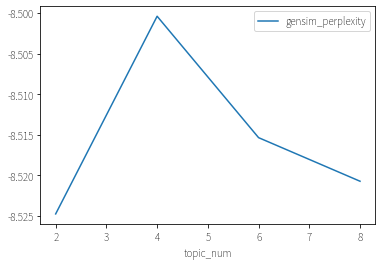

In [34]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-8.524730,5037.827849
1,4,-8.500414,4916.802744
2,6,-8.515348,4990.784648
3,8,-8.520711,5017.619536


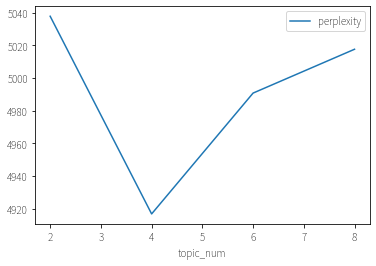

In [35]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

由perplexity可得知，4個topic是最合適的。

**以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題**

In [36]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.09166625, 0.0009090886, 0.00089713815, 0.9065275], [0.00044291164, 0.00044528343, 0.98421067, 0.014901117], [0.007262845, 0.007234058, 0.97824144, 0.0072616106]]


In [37]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [38]:
data[["artTitle","topic"]].head(5)

,artTitle,topic
16,[新聞]賴：操作萊豬擋國貿影響孩子未來,3
17,[新聞]許永輝：核四運轉測試難過關,2
28,Re:[新聞]許永輝：核四運轉測試難過關,2
33,[新聞]顏寬恒嗆高端成「4劑疫苗」林靜儀：讓國,3
36,[新聞]超商店員規勸顧客戴口罩遭刺民進黨團建,2


### 3.4 資料內容探索

#### 3.4.1查看兩個主題的內容

這次我們把討論焦點放在公投上，從主題分布大概可以看到兩類觀點：<br>
下方為第零個主題的相關文章，可以看到網友討論圍繞在公投上，包含公投結果、議題或相關事件。

In [39]:
# 核四相關文章
data[(data["topic"]==0)&(data["artTitle"].str.contains("公投"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
5555,[新聞]藍營喊公投已死黃暐瀚：拜託跳出同溫層,0
2604,Re:[新聞]1218公投》范雲批民進黨39秒影片被翻出,0
4283,[新聞]公投結果政府會遵守?柯文哲:民進黨政府不,0
1196,[新聞]銓敘部：公務員宣講公投不違法,0
2050,[問卦]有「公投」為什麼沒有「母投」,0


下方為第三個主題的相關文章，可以看到網友討論圍繞在公投的四大議題中上，如：「核四」、「同意不同意」。

In [40]:
# 國際關係
data[(data["topic"]==3)&(data["artTitle"].str.contains("公投"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
351,[問卦]怎麼反駁「核四公投過了也不會重啟，所以投同意票也不會怎麼樣」,3
2621,[新聞]投資族小心！謝金河示警四公投若「同意」,3
5273,[問卦]公投結果塔綠班是不是把自己逼進死胡同,3
1780,[問卦]公投不就是政府為了卸責嗎？,3
4626,[新聞]國民黨四大公投均出局林昶佐：下月9日,3


**畫出每日主題分布**

In [41]:
# 轉換artDate為 Python 日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y-%m-%d")

In [42]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

,artDate,topic,count
0,2021-11-22,0,3
1,2021-11-22,1,2
2,2021-11-22,2,10
3,2021-11-22,3,4
4,2021-11-23,0,5
...,...,...,...
113,2021-12-20,3,22
114,2021-12-21,0,12
115,2021-12-21,1,11
116,2021-12-21,2,13


In [43]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2', 'topic3']
date_df = date_df.set_index('artDate')
date_df.head(5)

,topic0,topic1,topic2,topic3
artDate,,,,
2021-11-22,3.0,2.0,10.0,4.0
2021-11-23,5.0,4.0,3.0,4.0
2021-11-24,4.0,5.0,3.0,10.0
2021-11-25,3.0,4.0,8.0,13.0
2021-11-26,0.0,5.0,4.0,2.0


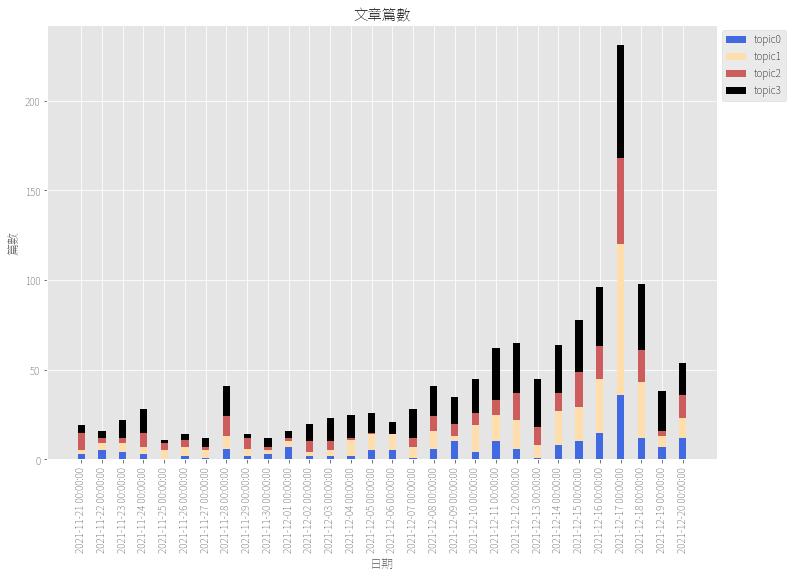

In [44]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

ind = np.arange(30)    
width = 0.35       

plt.bar(ind, date_df["topic0"], width, label="topic0",color='royalblue')
plt.bar(ind, date_df["topic1"], width,  bottom=date_df["topic0"], label="topic1",color='navajowhite')
plt.bar(ind, date_df["topic2"], width,  bottom=date_df["topic0"]+date_df["topic1"], label="topic2",color='indianred')
plt.bar(ind, date_df["topic3"], width,  bottom=date_df["topic0"]+date_df["topic1"]+date_df["topic2"], label="topic3",color='black')



#plt.bar(date_df.index, date_df["topic0"], width, label="topic0",color='royalblue')
#plt.bar(date_df.index, date_df["topic1"], width,  bottom=date_df["topic0"], label="topic1",color='navajowhite')
#plt.bar(date_df.index, date_df["topic2"], width,  bottom=date_df["topic0"]+date_df["topic1"], label="topic2",color='indianred')
#plt.bar(date_df.index, date_df["topic3"], width,  bottom=date_df["topic0"]+date_df["topic1"]+date_df["topic2"], label="topic3",color='black')


plt.xticks(rotation= 90, fontsize=10)
plt.xticks(ind,pd.date_range('2021/11/21','2021/12/22'))
#plt.xticks(ind, ('2021-12-16', '2021-12-17', '2021-12-18'))
plt.title('文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
# plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置

plt.show()

我們發現越接近公投當天，發文頻率越來越高，  
其中topic0（公投四議題）一直都是社群討論的中心，其次是topic2（核四重啟）。  
而發文最高峰在公投前一天（12/17），討論程度最高，篇數破200篇。

In [45]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3

for i in range(0,4):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df.head(5)

,topic0,topic1,topic2,topic3,sum
artDate,,,,,
2021-11-22,0.157895,0.105263,0.526316,0.210526,19.0
2021-11-23,0.312500,0.250000,0.187500,0.250000,16.0
2021-11-24,0.181818,0.227273,0.136364,0.454545,22.0
2021-11-25,0.107143,0.142857,0.285714,0.464286,28.0
2021-11-26,0.000000,0.454545,0.363636,0.181818,11.0


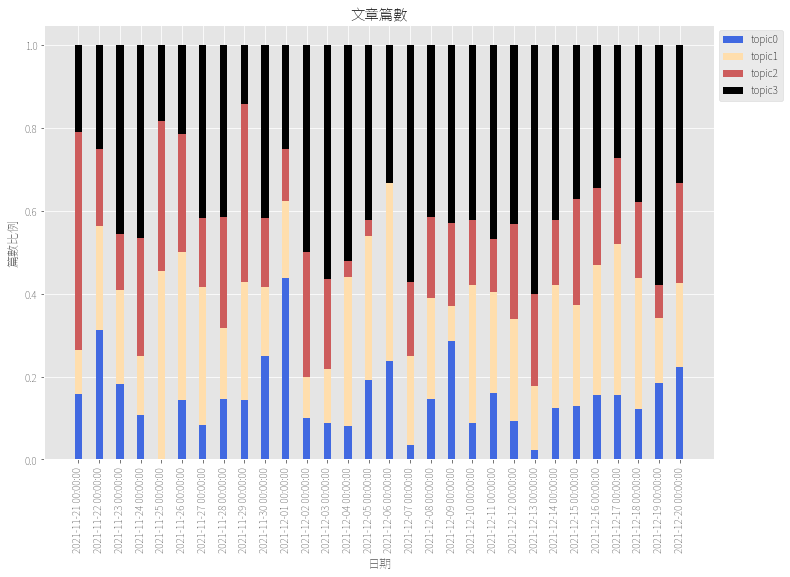

In [46]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

ind = np.arange(30)    
width = 0.35       

plt.bar(ind, ratio_df["topic0"], width, label="topic0",color='royalblue')
plt.bar(ind, ratio_df["topic1"], width,  bottom=ratio_df["topic0"], label="topic1",color='navajowhite')
plt.bar(ind, ratio_df["topic2"], width,  bottom=ratio_df["topic0"]+ratio_df["topic1"], label="topic2",color='indianred')
plt.bar(ind, ratio_df["topic3"], width,  bottom=ratio_df["topic0"]+ratio_df["topic1"]+ratio_df["topic2"], label="topic3",color='black')

plt.xticks(rotation= 90, fontsize=10)
plt.xticks(ind,pd.date_range('2021/11/21','2021/12/21'))
#plt.xticks(ind, ('2021-12-16', '2021-12-17', '2021-12-18'))
plt.title('文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數比例') # y軸標題
# plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置

plt.show()

各主題的討論程度每日都會浮動，可看出網友們對於公投的各討論topic都很熱烈。

### 3.5 N-gram 字詞相關網路圖

#### 為了更進一步的探討，我們將文章根據主題模型的結果進行分類，並且針對每個不同的主題文章進行 N-Gram 分析且繪製出字辭相關網路圖，目的是為了能更加瞭解主題模型所歸納出的 4 個主題分別有哪些意義。

In [49]:
data_topic1 = data[data['topic']==0] # 核四相關
data_topic2 = data[data['topic']==1] # 藻礁相關
data_topic3 = data[data['topic']==2] # 電力相關問題
data_topic4 = data[data['topic']==3] # 國際關係的看法

In [61]:
bigramfdist1 = FreqDist()
bigramfdist2 = FreqDist()
bigramfdist3 = FreqDist()
bigramfdist4 = FreqDist()

def bigram_getToken_dict(row,dist,n=2):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    dist.update(ngrams(seg_list, n))
    seg_list2 = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [62]:
data_topic1["word"] = data_topic1.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist1))
data_topic2["word"] = data_topic2.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist2))
data_topic3["word"] = data_topic3.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist3))
data_topic4["word"] = data_topic4.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist4))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [64]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d1 = {k:v for k,v in bigramfdist1.most_common(30)}
d2 = {k:v for k,v in bigramfdist2.most_common(30)}
d3 = {k:v for k,v in bigramfdist3.most_common(30)}
d4 = {k:v for k,v in bigramfdist4.most_common(30)}

In [65]:
G1 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d1][0].items():
    G1.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights1 = [w[2]['weight']*0.03 for w in  G1.edges(data=True)]

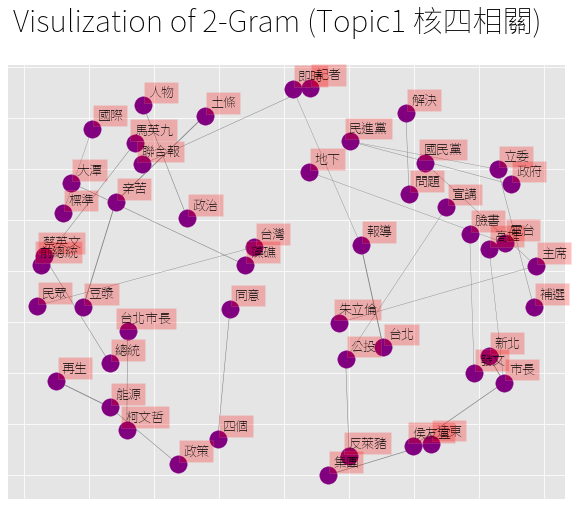

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G1, k=2)

# networks
nx.draw_networkx(G1, pos,
                 font_size=16,
                 width=weights1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic1 核四相關)', fontsize=30)    
plt.show()

透過上面所建立的bigram和count，我們選擇最常出現的前30大詞彙組合來製作出該關係圖。首先我們以第一個主題來製作字詞關係圖，可以發現「大潭 藻礁」、「四個 同意」、「公投 反萊豬」、「主席 朱立倫」、「再生 能源」等組合是最常被提及的前30個常見字詞組合。

In [68]:
G2 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d2][0].items():
    G2.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights2 = [w[2]['weight']*0.03 for w in  G2.edges(data=True)]

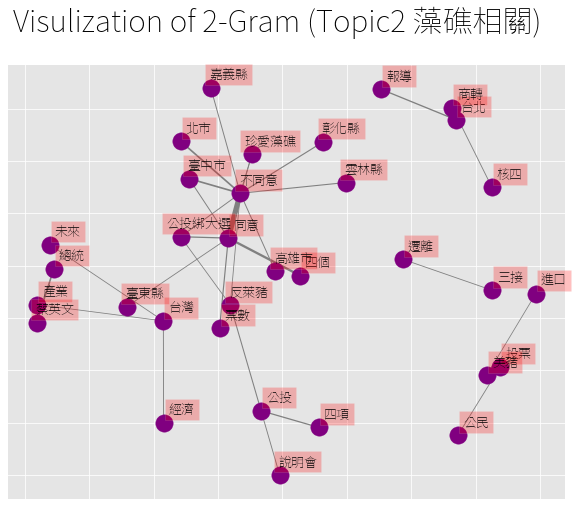

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G2, k=2)

# networks
nx.draw_networkx(G2, pos,
                 font_size=16,
                 width=weights2,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic2 藻礁相關)', fontsize=30)    
plt.show()

再來利用第二個主題來建立字詞關係圖，我們可以發現「同意 不同意」這個組合的線特別粗，也就是代表該字詞組合出現次數最多。其餘「三接 遷移」、四個 同意」、「珍愛藻礁 不同意」、「台中市 不同意」等組合也是很常被提及的前30個常見字詞組合。

In [72]:
G3 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d3][0].items():
    G3.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights3 = [w[2]['weight']*0.03 for w in  G3.edges(data=True)]

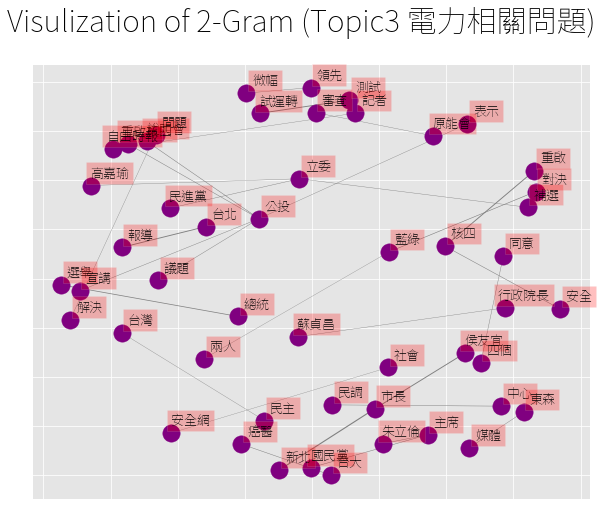

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G3, k=2)

# networks
nx.draw_networkx(G3, pos,
                 font_size=16,
                 width=weights3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic3 電力相關問題)', fontsize=30)    
plt.show()

第三個字詞關係圖則是利用第三個主題來建立，我們可以發現「核四 安全」、「公投 議題」、「四個 同意」、「重啟 核四」、「公投 宣講」等組合是最常被提及的前30個常見字詞組合。

In [74]:
G4 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d4][0].items():
    G4.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights4 = [w[2]['weight']*0.03 for w in  G4.edges(data=True)]

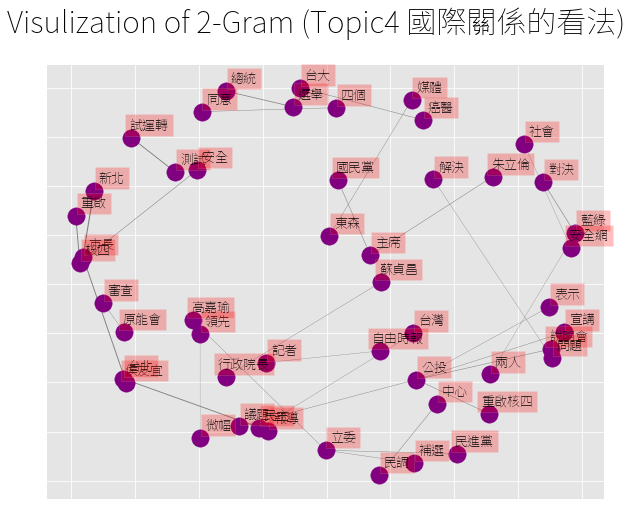

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G3, k=2)

# networks
nx.draw_networkx(G3, pos,
                 font_size=16,
                 width=weights3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic4 國際關係的看法)', fontsize=30)    
plt.show()

最後則是利用第四個主題來建立字詞關係圖，我們可以發現「四個 同意」、「國民黨 主席」、「東森 媒體」、「藍綠 對決」、「蘇貞昌 行政院長」等組合是最常被提及的前30個常見字詞組合。

雖然我們已經透過主題模型的結果，將文章切分成四個主題，但透過 N gram 字詞相關網路圖的結果會發現，各自不同主題的文章其實都有高度重疊的部分，因為我們再製作 字詞相關網路圖 時採用的統計量是字辭頻率，因此我們可以從以上的結果發現真正決定主題模型的主題劃分應當是在較少數的字詞上，但不同的主題文章大部分會出現的字詞幾乎都是一致的。而這個發現帶給我們的收穫是，如果要真正地繪製出不同主題下文章的 字詞相關網路圖 ，我們應當刪去那些共同出現在不同主題文章中的字詞，才更能夠看出不同主題文章下的內容差異。

## 4. 社群網路圖
社群網絡分析就是運用圖論(Graph theory)從這些節點和連結去研究人與人之間的關係以及整個群體的結構。

### 4.1 基本網路圖

In [35]:
data.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum,word,topic
16,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021-11-22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,",.:,自由時報,,,〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導〕,,,賴：操作...",52,"[自由, 時報, 劉曉欣, 冠備, 歐素, 建志, 淑媛, 綜合, 操作, 萊豬, 國貿, ...",3


In [36]:
Reviews.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021/11/22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,1.媒體來源:\n自由時報\n\n\n〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導...,:噓,Superxixai,噓,:噓


In [37]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [38]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,sum,word,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021-11-22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,",.:,自由時報,,,〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導〕,,,賴：操作...",52,"[自由, 時報, 劉曉欣, 冠備, 歐素, 建志, 淑媛, 綜合, 操作, 萊豬, 國貿, ...",3,Superxixai,噓,:噓,:噓
1,[新聞]賴：操作萊豬擋國貿影響孩子未來,2021-11-22,01:27:35,https://www.ptt.cc/bbs/Gossiping/M.1637544457....,a23006010103,Gossiping,144,14,38,",.:,自由時報,,,〔記者劉曉欣、陳冠備、歐素美、陳建志、蔡淑媛／綜合報導〕,,,賴：操作...",52,"[自由, 時報, 劉曉欣, 冠備, 歐素, 建志, 淑媛, 綜合, 操作, 萊豬, 國貿, ...",3,scott01,噓,:中共同路人,:中共同路人


In [39]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,Superxixai,a23006010103,https://www.ptt.cc/bbs/Gossiping/M.1637544457....
1,scott01,a23006010103,https://www.ptt.cc/bbs/Gossiping/M.1637544457....
2,cp109,a23006010103,https://www.ptt.cc/bbs/Gossiping/M.1637544457....
3,AustinRivers,a23006010103,https://www.ptt.cc/bbs/Gossiping/M.1637544457....
4,gk1329,a23006010103,https://www.ptt.cc/bbs/Gossiping/M.1637544457....


In [40]:
len(link)

307440

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結，這裡先嘗試使用前100筆資料(總共有307440筆資料)

In [41]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])

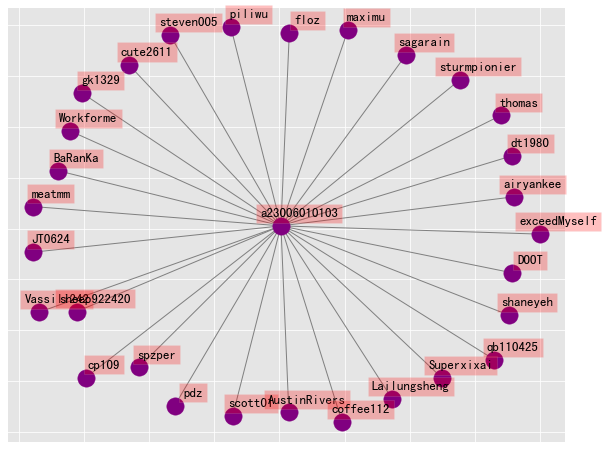

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

資料太多太雜(307440筆資料)，所以我們下面需要做進一步篩選。

### 4.2 資料篩選

資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

看一下文章留言數大概都多少(方便後面篩選)

Text(0, 0.5, 'count')

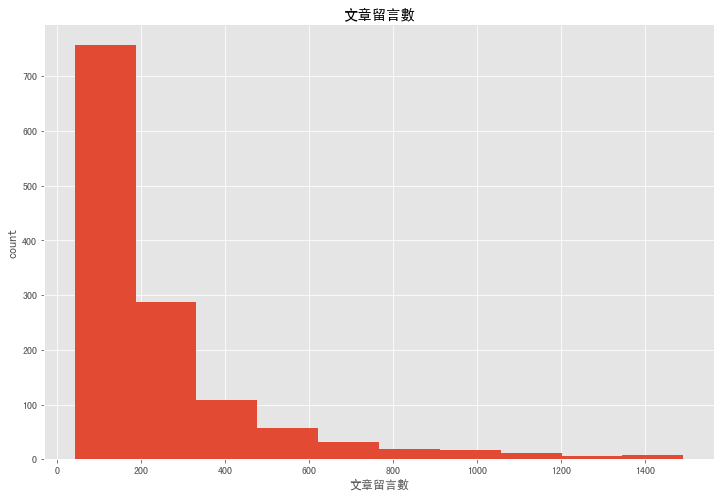

In [43]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

由上圖結果可以知道文章留言數大多在300則以內。

依據發文數或回覆數篩選post和review

In [44]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
832,zzyyxx77,12
261,benoaico,11
549,lycppt,11
79,Hyuui,10
359,eatk,10
...,...,...
409,h5566,1
138,RTA,1
136,Pittsburgh,1
413,hank81177,1


In [45]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 835
回覆者數量總共: 28460


**標記所有出現過的使用者**
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [46]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [47]:
allPoster = pd.DataFrame(list(s),columns=["user"])

In [48]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replayer")

In [49]:
allPoster.head(5)

,user,type
0,chipei27,poster
1,aagain,replayer
2,davxyz,replayer
3,rthen,replayer
4,garry0403,replayer


### 4.3 以日期篩選社群

我們挑出公投當天12-18的文章和回覆

In [50]:
# 篩選日期為2021-12-18 且 留言數>300的
posts_Reviews_1218 = (posts_Reviews.query('artDate == "2021-12-18"')
                      .query('commentNum>300')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [51]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_1218 = posts_Reviews_1218.query('size>5')
posts_Reviews_1218.head(3)

,cmtPoster,artUrl,size
5,AAA891216,https://www.ptt.cc/bbs/Gossiping/M.1639789117....,10
48,ASEVE,https://www.ptt.cc/bbs/Gossiping/M.1639830110....,7
84,AlenCKH,https://www.ptt.cc/bbs/Gossiping/M.1639790432....,9


In [52]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1218 = pd.merge(posts_Reviews_1218,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1218.reset_index(inplace=True, drop=True) #重設index
link_1218.head(3)

,cmtPoster,artUrl,size,artPoster
0,AAA891216,https://www.ptt.cc/bbs/Gossiping/M.1639789117....,10,ihaveseven
1,ASEVE,https://www.ptt.cc/bbs/Gossiping/M.1639830110....,7,benoaico
2,AlenCKH,https://www.ptt.cc/bbs/Gossiping/M.1639790432....,9,leocean9816


In [53]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_1218)):
    G.add_edge(link_1218["cmtPoster"][i], link_1218["artPoster"][i])

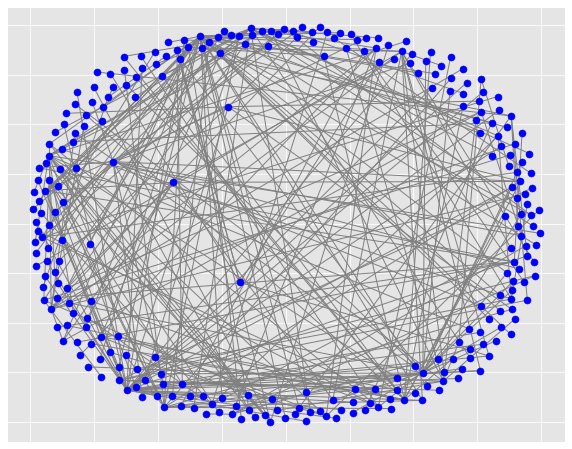

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

**加上nodes的顯示資訊**  
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [55]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

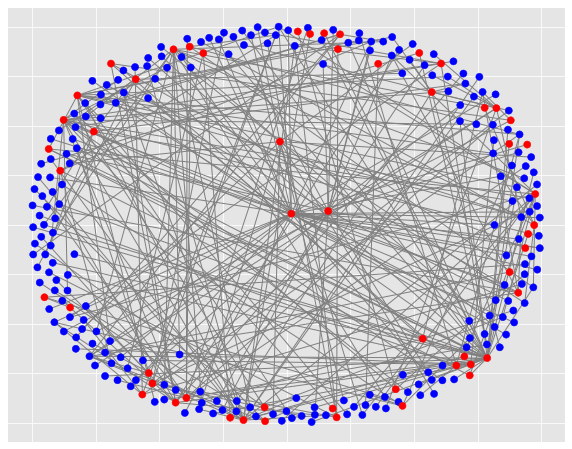

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

為點加上帳號名字，用degree篩選要顯示出的使用者(degree>5)，以免圖形被密密麻麻的文字覆蓋。  

In [57]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [58]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [59]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

['benoaico',
 'JustBecauseU',
 'mandalin',
 'KagamiRaito',
 'omniallme',
 'kl50365',
 'Number87',
 'peterwww']

In [60]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

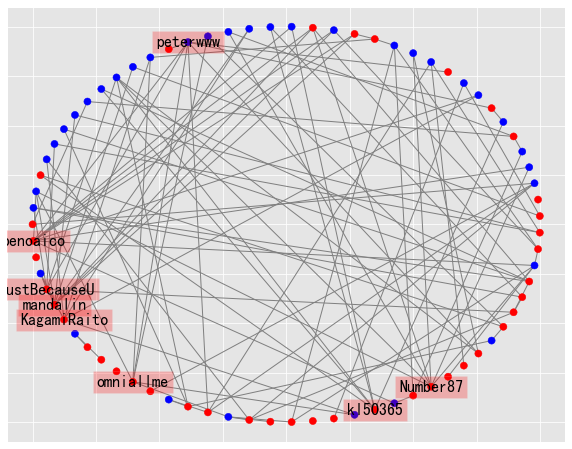

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

**計算Centrality**  
找出重要的點  
[NetworkX Centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)  

- degree centrality: people with many connections tend to be important
- eigenvector centrality: people who are connected to more important people tend to be important
- pagerank centrality: remedy Eigenvector measure by normalization
- betweenness centrality: People who connect to more communities tend to be more important

In [62]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'ihaveseven': 0.02702702702702703,
 'benoaico': 0.13513513513513514,
 'leocean9816': 0.0,
 'Anvec': 0.04054054054054054,
 'JustBecauseU': 0.08108108108108109,
 'mandalin': 0.10810810810810811,
 'KagamiRaito': 0.08108108108108109,
 'Atwo': 0.02702702702702703,
 'abc1204': 0.013513513513513514,
 'Waitaha': 0.013513513513513514,
 'gerllay0205': 0.0,
 'omniallme': 0.08108108108108109,
 'nixing': 0.013513513513513514,
 'DinoZavolta': 0.02702702702702703,
 'zxcvbbb': 0.05405405405405406,
 'wa007123456': 0.05405405405405406,
 'Ghamu': 0.05405405405405406,
 'hydra3179': 0.05405405405405406,
 'DoncicInPTT': 0.013513513513513514,
 'cmcmisgod': 0.04054054054054054,
 'sukiya': 0.0,
 'F20V': 0.013513513513513514,
 'Kaken': 0.02702702702702703,
 'kl50365': 0.08108108108108109,
 'Nighty7222': 0.02702702702702703,
 'opie': 0.04054054054054054,
 'Number87': 0.0945945945945946,
 'HardenJames': 0.013513513513513514,
 'Syoshinsya': 0.04054054054054054,
 'sweat992001': 0.04054054054054054,
 'WTF55665566':

In [63]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [64]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

In [65]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [66]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['benoaico', 'mandalin', 'peterwww', 'Number87', 'JustBecauseU']
eigenvector centrality: ['benoaico', 'mandalin', 'Number87', 'peterwww', 'yudofu']
pagerank centrality: ['benoaico', 'peterwww', 'mandalin', 'Number87', 'kl50365']
betweenness centrality: ['peterwww', 'benoaico', 'mandalin', 'Number87', 'omniallme']


最多的是benoaico、mandalin、peterwww，這三人在社群中是重要的節點。

### 4.4 以主題篩選社群

挑選出2021-12-18當天的文章， 篩選一篇文章回覆5次以上者，且文章留言數大於200則。<br>
文章主題歸類為0(核四相關)與2(電力相關問題)者。<br>
欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [67]:
# 加上topic
topic_1218 = pd.merge(link_1218,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [68]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1218_topic = pd.merge(topic_1218,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1218_topic.reset_index(inplace=True, drop=True) #重設index
link_1218_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,AAA891216,https://www.ptt.cc/bbs/Gossiping/M.1639789117....,0,ihaveseven
1,ASEVE,https://www.ptt.cc/bbs/Gossiping/M.1639830110....,1,benoaico
2,AlenCKH,https://www.ptt.cc/bbs/Gossiping/M.1639790432....,3,leocean9816


In [69]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_1218_topic)):
    G.add_edge(link_1218_topic["cmtPoster"][i], link_1218_topic["artPoster"][i])
    if link_1218_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') # 主題零:報導相關
    else: 
        color_map_edge.append('grey') # 主題二:調侃相關   

In [70]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [71]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [72]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

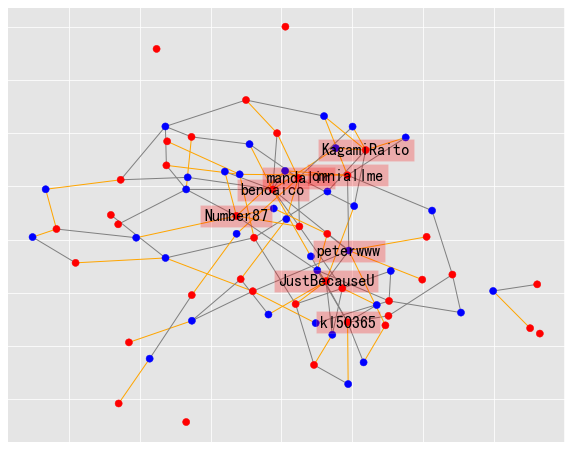

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

核四相關為橘色，電力相關問題為灰色。可以看出mandalin較多為核四相關留言，peterwww較多是電力相關問題留言。

### 4.5 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [74]:
# 加上status
status_1218 = pd.merge(link_1218,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_1218 = status_1218[status_1218["cmtStatus"]!="→"]

In [75]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1218_status = pd.merge(status_1218,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1218_status.reset_index(inplace=True, drop=True) #重設index
link_1218_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,AAA891216,https://www.ptt.cc/bbs/Gossiping/M.1639789117....,0,噓,ihaveseven
1,AAA891216,https://www.ptt.cc/bbs/Gossiping/M.1639789117....,0,推,ihaveseven
2,ASEVE,https://www.ptt.cc/bbs/Gossiping/M.1639830110....,1,推,benoaico


In [76]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_1218_status)):
    G.add_edge(link_1218_status["cmtPoster"][i], link_1218_status["artPoster"][i])
    if link_1218_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [77]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [78]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [79]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

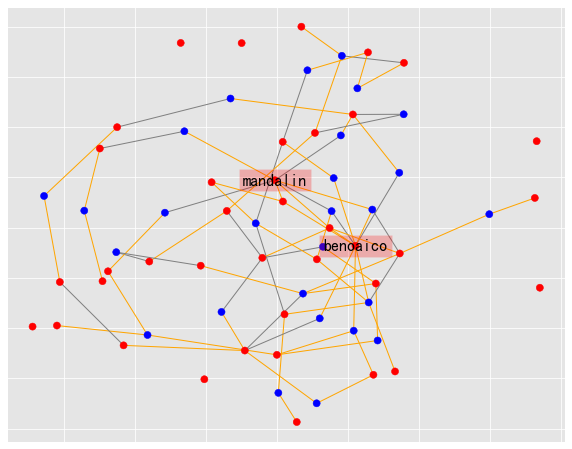

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

推文為橘色，噓文為灰色。可以發現本次的討論中幾乎都是推文、噓文較少。

#### 看受歡迎使用者發布的文章與留言
benoaico、mandalin兩位為受歡迎的使用者。首先，先看「benoaico」發布的文章與留言。

In [81]:
MetaData = pd.read_csv('./raw_data/vote_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/vote_articleReviews.csv', encoding='UTF-8')

In [82]:
filter1 = MetaData["artPoster"] == "benoaico"
MetaData[filter1]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
307,[新聞]三接外推有多遠？蔡英文：台北車站到中,2021/11/25,06:52:32,https://www.ptt.cc/bbs/Gossiping/M.1637823154....,benoaico,Gossiping,46,9,14,https://www.setn.com/m/ampnews.aspx?NewsID=103...
1115,[新聞]蘇貞昌宣講4個不同意行程滿檔意外曝結,2021/12/05,04:54:28,https://www.ptt.cc/bbs/Gossiping/M.1638680070....,benoaico,Gossiping,99,7,49,https://news.ltn.com.tw/amp/news/politics/brea...
1308,[新聞]反對核四重啟民進黨立委呼籲同島一命,2021/12/07,04:30:23,https://www.ptt.cc/bbs/Gossiping/M.1638851426....,benoaico,Gossiping,55,18,20,https://udn.com/news/amp/story/12539/5943290\n...
1821,[新聞]賴清德合體賴品妤四個不同意「高顏值」,2021/12/11,03:56:42,https://www.ptt.cc/bbs/Gossiping/M.1639195004....,benoaico,Gossiping,86,26,28,https://news.ltn.com.tw/news/politics/breaking...
2070,[新聞]談萊豬公投陳時中：討論超劑量居心叵測,2021/12/12,04:13:32,https://www.ptt.cc/bbs/Gossiping/M.1639282415....,benoaico,Gossiping,105,22,31,https://udn.com/news/amp/story/12539/5955966\n...
2272,[新聞]避免受騙看這裡！9大公投奧步曝光民進,2021/12/13,00:30:45,https://www.ptt.cc/bbs/Gossiping/M.1639355447....,benoaico,Gossiping,101,16,49,https://www.ettoday.net/amp/amp_news.php7?news...
2665,[新聞]1218公投倒數！林昶佐女兒許聖誕願望,2021/12/14,07:33:31,https://www.ptt.cc/bbs/Gossiping/M.1639467213....,benoaico,Gossiping,88,33,24,https://www.ftvnews.com.tw/news/detail/2021C14...
2818,[新聞]四大公投「中共表態了」！國台辦：台灣,2021/12/15,03:47:28,https://www.ptt.cc/bbs/Gossiping/M.1639540050....,benoaico,Gossiping,183,82,40,https://www.setn.com/m/news.aspx?NewsID=104226...
3100,[新聞]來了！中共操弄公投離間台美關係民進黨,2021/12/16,05:20:27,https://www.ptt.cc/bbs/Gossiping/M.1639632029....,benoaico,Gossiping,46,13,15,https://www.setn.com/m/ampnews.aspx?NewsID=104...
3460,[新聞]林靜儀：反美豬阻經濟難道要像馬時代到,2021/12/17,04:26:54,https://www.ptt.cc/bbs/Gossiping/M.1639715216....,benoaico,Gossiping,232,33,106,https://udn.com/news/amp/story/12539/5968677\n...


In [83]:
filter2 = Reviews["cmtPoster"] == "benoaico"
Reviews[filter2]['cmtContent']

88345                     :垃圾菜
122043                    :智障女
125963                     :智障
130980                     :白癡
135845                   :垃圾側翼
147614                     :垃圾
162905         :用愛發電至少佔20%馬忘了算
205113          :沒水準民主投票是這樣搞的?
208272    :2024蘇出來選哦那可能朱出來就能贏了
211145                :史上最垃圾總統
211790       :民進黨爽爆了一個公投讓國民黨分裂
236335           :笑死下面堆覺青在搞車高潮
346185                 :本來就兩件事
349327        :幹公投結果一出來塔綠班傾巢而出
351909                 :南部的民意嗎
352244               :傾巢而出大舉反攻
352451             :不是侯友宜就是柯文哲
357758              :侯友宜哪裡有重傷？
358839         :智障治國難怪投票結果那麼智障
360904                     :事實
361128            :塔綠班台中彰化繼續做夢
366590      :他的格局可以當總統了比起現在那個母
369031            :搬出數據了塔綠班還要崩
390877                    :關回去
395115             :喔所以她現在當皇帝嗎
397017          :他的確是講錯了還有一個台南
402393                   :垃圾政黨
Name: cmtContent, dtype: object

查看「mandalin」發布的文章與留言。

In [87]:
filter3 = MetaData["artPoster"] == "mandalin"
MetaData[filter3]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
4594,[新聞]台北市投票率全國第1！四大公投「同意」,2021/12/18,13:13:59,https://www.ptt.cc/bbs/Gossiping/M.1639833241....,mandalin,Gossiping,971,482,74,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n\n自由\n\n2.記者署名:\n...


In [89]:
filter4 = Reviews["cmtPoster"] == "mandalin"
Reviews[filter4]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
328117,[新聞]「公投結束別鬆懈！」林昶佐喊話：對罷免,2021/12/18,14:09:03,https://www.ptt.cc/bbs/Gossiping/M.1639836545....,eatk,Gossiping,mandalin,噓,2021-12-18 22:10:00,:這時候閃尿趕快忙著出來蹭


In [93]:
filter5 = Reviews["cmtPoster"] == "peterwww"
Reviews[filter5]['cmtContent'].head(50)

58112              :太關鍵的消息！真台灣良心
58118               :早就說過一定要追查到底
58122                :將整個論文門徹查到底
58154                       :致敬！
58161          :賀德芬教授致敬這才是台灣進步力量
58169         :不畏權勢與民粹之猛攻引領台灣人昂揚
85252        :沒看過這種小黨直接跟民進黨領錢不就好
86843            :不會滅民進黨啦他們很懂生存的
89421          :理組:妳能拿多少是看妳的價值?咦
89440              :林錫耀說輸了還是他們執政
89441                :不一樣啊!林錫耀先生
95882                :萬華被污名化說是破口
95954          :不可以托六尺之孤不可以寄百里之命
95956                  :無德之人敢用嗎？
95957                   :等等帳簿都偷走
125195       :贏一票就是大勝不用覺得只贏泛綠一點點
125196              :畢竟世人的思想太多奇葩
125200                    :還涉及利益
125211        :擺脫民進黨情緒勒索台灣人才能奪回主
125212                       :導權
125383                 :勿忘歷史昆陽之戰
135669              :不可思議這還有良心嗎？
147693              :真的把台灣人當禁臠耶！
147984             :網軍就是：抹黑造謠帶風向
147985        :勾惡整個把故事都串起來了民進黨已經
147986            :非昔日民進黨以後台派會流淚
147987    :怎麼當初會覺得蔡英文是個丁丁啊......
147988           :能夠贏賴清德是多麼可怕的逆轉
147989               :短時間內耶開什麼玩笑
147990       :包括民調三份民進黨內良知者都應該徹查
147992    